In [147]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf 
import os
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
# from functions_forecasting import *
sns.set_theme()


# Price Forecasting
***

In [152]:
# data
ticker = 'AAPL'
start_date = '2010-01-02'
end_date = '2021-04-28'
n_lags = 3

valid_size = 12
test_size = 12
batch_size = 3
n_epochs = 1000

In [168]:
df = yf.download(ticker,
    start = start_date,
    end = end_date,
    progress = False)

df = df.resample('M').last()
prices = df['Adj Close'].values

In [169]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,134.080002,134.740005,131.720001,132.690002,132.492020,99116600
2021-01-31,135.830002,136.740005,130.210007,131.960007,131.763107,177180600
2021-02-28,122.589996,124.849998,121.199997,121.260002,121.260002,164320000
2021-03-31,121.650002,123.519997,121.150002,122.150002,122.150002,118323800
2021-04-30,135.009995,135.410004,134.110001,134.389999,134.389999,66015800


Text(0, 0.5, 'Price ($)')

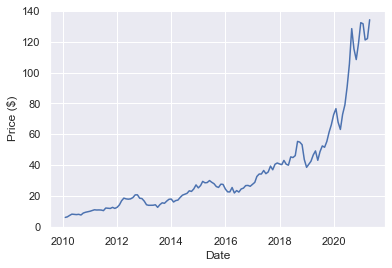

In [170]:
fig, ax = plt.subplots( )

ax.plot(df.index, prices)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

A function to split the sequences:

In [171]:
def split_sequence(sequence, n_steps_in, n_steps_out, min_index, max_index):
    '''
    Function for transforming time series into input acceptable by multilayer perceptron.abs

    Parameters
    ----------
    series : np.array
        Array of features 
    n_steps_in : int
        The number of lagged observations to consider as features
    min_index, max_index : int 
        Indices in the data array that delimit which timesteps to draw from.

    Returns 
    -------
    X : np.array 
        Array of features 
    Y : np.array 
        Array of features
    '''

    X, y = list(), list()
    if max_index is None:
        max_index = len(sequence) - n_steps_out - 1
    for i in range(min_index,len(sequence)):
        # find the end of this pattern
        end_ix =  i + n_steps_in
        out_end_ix =  end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > max_index:
            break
        # gather input and output parts of the pattern
        yield sequence[i:end_ix], sequence[end_ix:out_end_ix]

Split into training and validaiton sets and test sets:

In [172]:
train_max = int(0.8*len(prices))
train_max
len(prices)

136

In [190]:
X_train = split_sequence(prices,3,1,0,train_max)
X_val = split_sequence(prices,3,1,train_max+1, None )

i = 0
j = 0
for x in X_train:
    i +=1
for x in X_val:
    j += 1

print(f'Size of datasets - training: {i} | validation: {j}')

X_train = split_sequence(prices,3,1,0,train_max)
X_val = split_sequence(prices,3,1,train_max+1, None )

Size of datasets - training: 105 | validation: 22


In [92]:
# One step behind!
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]
mse = tf.keras.losses.MeanSquaredError()
naive_mse = mse(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 11108.53, RMSE: 105.40


Build our model:

In [191]:
class MLP(tf.keras.Model):

    # In __init__, we define the Model's layers
    def __init__(self,steps_out, batch_size):
        super(MLP, self).__init__()
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu', input_shape=(3,))
        self.drop_out_layer_1 = tf.keras.layers.Dropout(0.2)
        self.dense_layer2 = tf.keras.layers.Dense(4, activation = 'relu' )
        self.drop_out_layer_2 = tf.keras.layers.Dropout(0.2)
        self.dense_layer3 = tf.keras.layers.Dense(steps_out, activation = 'relu' )

    # In the call function, we define the Model's forward pass.
    def build(self):
        model = tf.keras.Sequential([
        # Layer 1: 
        self.dense_layer1,
        self.drop_out_layer_1,
        # Layer 2:
        self.dense_layer2,
        self.drop_out_layer_2,
        # Layer 3:
        self.dense_layer3 
        ])

        return model

Hyperparameter setting and optimization:

In [192]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
n_epochs = 10
batch_size = 3 
learning_rate = 0.0001 

# Model parameters: 
steps_in = 3
steps_out = 1

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Build model:

In [193]:
tf.random.set_seed(42)

model = MLP(steps_out, batch_size).build()
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


## Begin training!
***

In [194]:
@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:

        y_hat = model(x) # TODO

        loss = mse(y, y_hat) # TODO

        # Now, compute the gradients 
        grads = tape.gradient(loss, model.trainable_variables) # TODO

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [97]:
history = []
history_val = []
losses_val = []

for epoch in tqdm(range(40)):
    for i in range(len(X_train)):
        # Grab a batch and propagate it through the network
        x_batch, y_batch = X_train[i].reshape(1,batch_size), y_train[i].reshape(1,1)
        loss = train_step(x_batch, y_batch)

        # Update the progress bar
        history.append(loss.numpy().mean())

        # Update validation loss history
        for j in range(len(X_val)):
            y_hat = model(X_train[j].reshape(1,batch_size))
            losses_val.append( mse(y_hat, y_val[j].reshape(1,1)).numpy() )
            
        history_val.append(np.asarray(losses_val).mean())
        losses_val = []
      
model.save_weights(checkpoint_prefix)

100%|██████████| 40/40 [01:03<00:00,  1.60s/it]


Plot training loss data:

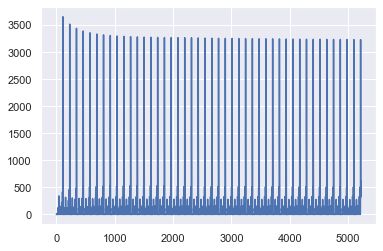

In [105]:
fig, ax = plt.subplots()
ax.plot(history)

Plot validation loss data:

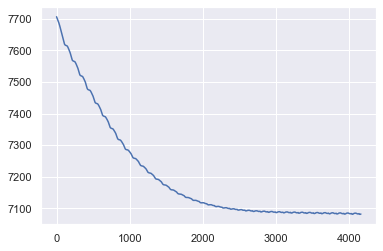

In [106]:
fig, ax = plt.subplots()
ax.plot(history_val)

In [107]:
# fig, ax = plt.subplots()
# ax.plot(history_val[8*len(X_train):9*len(X_train)])

Thus, 8 epochs seems optimal. Retrain the network with 8 epochs:

In [108]:
X_train = X[:-valid_size]
y_train = y[:-valid_size].reshape(-1,1)
history = []

for epoch in tqdm(range(45)):
    for i in range(len(X_train)):
        # Grab a batch and propagate it through the network
        x_batch, y_batch = X_train[i].reshape(1,batch_size), y_train[i].reshape(1,1)
        loss = train_step(x_batch, y_batch)

        # Update the progress bar
        history.append(loss.numpy().mean())

model.save_weights(checkpoint_prefix)

100%|██████████| 45/45 [00:01<00:00, 23.58it/s]


In [109]:
y_hat = model(X_test)

In [110]:
predictions = y_hat.numpy().flatten()

Text(0, 0.5, 'Price ($)')

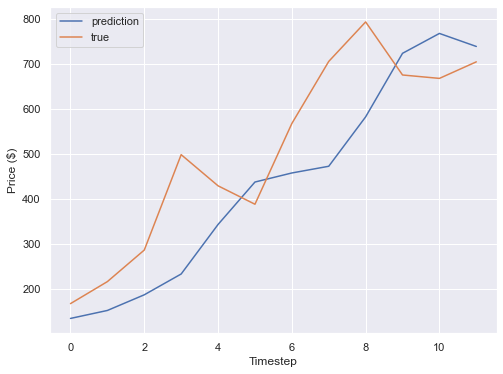

In [113]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(predictions, label='prediction')
ax.plot(y_test, label = 'true')
ax.legend()
ax.set_xlabel('Timestep')
ax.set_ylabel('Price ($)')